In [1]:
import numpy as np
import pandas as pd
import regex as re
from collections import defaultdict

from sklearn import preprocessing, model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn.utils import class_weight

# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg
try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None
    
from stellargraph import StellarDiGraph
from stellargraph.mapper import DirectedGraphSAGENodeGenerator
from stellargraph.layer import DirectedGraphSAGE, MaxPoolingAggregator, MeanAggregator, MeanPoolingAggregator

from tensorflow.keras import layers, optimizers, losses, metrics, Model
import matplotlib.pyplot as plt
# %matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)

### Load Data

In [2]:
nodes_df = pd.read_csv('../../ModelPrototype/activityNodes.csv')
nodes_df = nodes_df[(nodes_df['placeType'] == nodes_df['placeType']) & (nodes_df['placeType'] != 'OTHER')].reset_index()
userIds = nodes_df.userId.unique()
nodes_df.head()

,index,userId,cid,posLon,posLat,x,y,poiList,typeCount,weekday_hours,...,weekday_hours_all,weekend_hours_all,dow_duration,max_nexttime,avg_nexttime,max_nextdist,avg_nextdist,max_speed,avg_speed,placeType
0,4,1,5,-89.290268,43.093387,577761.499079,291429.766273,"[turning_circle, park]","{Entertainment=1, Transportation_network=1}","0,0,0,0,0,1,10,183,137,46,21,79,81,133,90,127,94,34,20,3,2,0,0,0,",...,"[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,4,0,0,0,0,0,0,0,];[0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,3,1,1,0,0,0,0...","[0,0,0,0,0,0,0,8,1,3,0,0,0,3,1,0,0,0,0,0,0,0,0,0,];[0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,10,0,0...","[[0.0,0.0,0.0,0.0,0.0,0.0,0.0,];[0.0,0.0,0.0,43.0,0.0,0.0,0.0,];[0.0,0.0,0.0,0.0,536.0,0.0,0.0,]...",509.0,15.0,2529.736171,47.801399,719.658091,60.816443,HOME
1,5,1,6,-89.303390,43.084478,576701.779784,290431.461915,"[crossing, crossing, crossing, crossing, crossing, crossing, crossing, crossing, traffic_signals...","{Transportation_network=14, Shopping=3, Eating=2, Health=1, Service=1}","0,0,0,0,0,0,0,0,13,36,32,390,282,81,72,175,91,59,0,0,0,0,0,0,",...,"[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,18,0,0,0,0,0,0,0,];[0,0,0,0,0,0,0,0,0,0,0,3,24,0,0,16,0,0,0,0,0...","[0,0,0,0,0,0,0,0,0,23,0,28,0,0,0,0,0,0,0,0,0,0,0,0,];[0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,...","[[0.0,0.0,0.0,0.0,0.0,0.0,0.0,];[0.0,0.0,0.0,8.0,0.0,0.0,0.0,];[0.0,0.0,0.0,0.0,229.0,0.0,0.0,];...",49.0,3.0,507.462491,30.641881,872.813225,61.384740,ERRANDS
2,8,1,9,-89.326535,43.059192,574840.387565,287608.059077,"[parking, hairdresser, butcher, building, building, building, building, building, building, buil...","{Others=9, Entertainment=1, Shopping=1, Transportation_network=1}","0,0,0,0,0,0,0,0,13,33,17,0,0,0,0,0,0,0,0,0,0,0,0,0,",...,"[0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,];[0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0...","[0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,];","[[0.0,0.0,0.0,0.0,0.0,0.0,0.0,];[0.0,0.0,0.0,0.0,20.0,0.0,0.0,];[0.0,0.0,6.0,0.0,0.0,0.0,0.0,];[...",19.0,2.0,313.643799,27.537346,375.417811,43.724569,ERRANDS
3,10,1,11,-89.292776,43.090184,577560.384526,291072.346581,NaN,NaN,"0,0,0,0,0,0,0,16,11,0,0,9,34,16,36,38,11,23,4,0,0,0,0,0,",...,"[0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,3,0,0,0,0,0,0,0,0,];[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,...","[0,0,0,0,0,0,0,0,0,2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,];[0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,3,0,0,...","[[0.0,0.0,0.0,0.0,0.0,0.0,0.0,];[0.0,0.0,0.0,0.0,153.0,0.0,0.0,];[0.0,0.0,0.0,0.0,0.0,0.0,82.0,]...",411.0,31.0,410.116934,47.778646,465.982649,64.019991,HOME OF FAMILY MEMBER
4,11,1,12,-89.322396,43.083813,575155.345007,290344.940020,"[bar, bank, library, recycling, building, building, building, building, building, building]","{Others=6, Education=1, Work=1, Drinking=1, Service=1}","0,0,0,0,0,0,0,0,92,18,40,6,21,5,17,9,0,0,0,0,0,0,0,0,",...,"[0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,];[0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,...","[0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,];[0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,...","[[0.0,0.0,0.0,0.0,0.0,0.0,0.0,];[0.0,0.0,0.0,0.0,0.0,10.0,0.0,];[0.0,0.0,0.0,12.0,0.0,0.0,0.0,];...",17.0,1.0,344.429258,30.174615,1130.900473,59.816287,ERRANDS


### Aggregate label types

In [3]:
def aggregate_label_types(placetype):
    placetype_str = placetype.loc['placeType']
    if placetype_str in {'HOME'}:
        return placetype_str
    elif placetype_str in {'WORK', 'SCHOOL'}:
        return 'WORK'
    elif placetype_str in {'ERRANDS'}:
        return 'SHOPPING'
    elif placetype_str in {'LIQUOR STORE'}:
        return placetype_str
    elif placetype_str in {'BAR', 'RESTAURANT'}:
        return 'PUBLIC DRINKING SPACES'
    elif placetype_str in {'VOLUNTEER', 'CHURCH', 'COFFEE SHOP/CAFE', 'PARK'}:
        return 'PUBLIC COMMUNITY SPACES'
    elif placetype_str in {'GYM/FITNESS CENTER', 'HEALTH CARE', 'AA/RECOVERY MEETING'}:
        return 'HEALTH'
    elif placetype_str in {'HOME OF FAMILY MEMBER', 'HOME OF FRIEND'}:
        return 'OTHERS HOME'
    else:
        return 'OTHERS'

In [4]:
nodes_df['labelType'] = nodes_df[['placeType']].apply(lambda x: aggregate_label_types(x), axis=1)
nodes_df.head()

,index,userId,cid,posLon,posLat,x,y,poiList,typeCount,weekday_hours,...,weekend_hours_all,dow_duration,max_nexttime,avg_nexttime,max_nextdist,avg_nextdist,max_speed,avg_speed,placeType,labelType
0,4,1,5,-89.290268,43.093387,577761.499079,291429.766273,"[turning_circle, park]","{Entertainment=1, Transportation_network=1}","0,0,0,0,0,1,10,183,137,46,21,79,81,133,90,127,94,34,20,3,2,0,0,0,",...,"[0,0,0,0,0,0,0,8,1,3,0,0,0,3,1,0,0,0,0,0,0,0,0,0,];[0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,10,0,0...","[[0.0,0.0,0.0,0.0,0.0,0.0,0.0,];[0.0,0.0,0.0,43.0,0.0,0.0,0.0,];[0.0,0.0,0.0,0.0,536.0,0.0,0.0,]...",509.0,15.0,2529.736171,47.801399,719.658091,60.816443,HOME,HOME
1,5,1,6,-89.303390,43.084478,576701.779784,290431.461915,"[crossing, crossing, crossing, crossing, crossing, crossing, crossing, crossing, traffic_signals...","{Transportation_network=14, Shopping=3, Eating=2, Health=1, Service=1}","0,0,0,0,0,0,0,0,13,36,32,390,282,81,72,175,91,59,0,0,0,0,0,0,",...,"[0,0,0,0,0,0,0,0,0,23,0,28,0,0,0,0,0,0,0,0,0,0,0,0,];[0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,...","[[0.0,0.0,0.0,0.0,0.0,0.0,0.0,];[0.0,0.0,0.0,8.0,0.0,0.0,0.0,];[0.0,0.0,0.0,0.0,229.0,0.0,0.0,];...",49.0,3.0,507.462491,30.641881,872.813225,61.384740,ERRANDS,SHOPPING
2,8,1,9,-89.326535,43.059192,574840.387565,287608.059077,"[parking, hairdresser, butcher, building, building, building, building, building, building, buil...","{Others=9, Entertainment=1, Shopping=1, Transportation_network=1}","0,0,0,0,0,0,0,0,13,33,17,0,0,0,0,0,0,0,0,0,0,0,0,0,",...,"[0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,];","[[0.0,0.0,0.0,0.0,0.0,0.0,0.0,];[0.0,0.0,0.0,0.0,20.0,0.0,0.0,];[0.0,0.0,6.0,0.0,0.0,0.0,0.0,];[...",19.0,2.0,313.643799,27.537346,375.417811,43.724569,ERRANDS,SHOPPING
3,10,1,11,-89.292776,43.090184,577560.384526,291072.346581,NaN,NaN,"0,0,0,0,0,0,0,16,11,0,0,9,34,16,36,38,11,23,4,0,0,0,0,0,",...,"[0,0,0,0,0,0,0,0,0,2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,];[0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,3,0,0,...","[[0.0,0.0,0.0,0.0,0.0,0.0,0.0,];[0.0,0.0,0.0,0.0,153.0,0.0,0.0,];[0.0,0.0,0.0,0.0,0.0,0.0,82.0,]...",411.0,31.0,410.116934,47.778646,465.982649,64.019991,HOME OF FAMILY MEMBER,OTHERS HOME
4,11,1,12,-89.322396,43.083813,575155.345007,290344.940020,"[bar, bank, library, recycling, building, building, building, building, building, building]","{Others=6, Education=1, Work=1, Drinking=1, Service=1}","0,0,0,0,0,0,0,0,92,18,40,6,21,5,17,9,0,0,0,0,0,0,0,0,",...,"[0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,];[0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,...","[[0.0,0.0,0.0,0.0,0.0,0.0,0.0,];[0.0,0.0,0.0,0.0,0.0,10.0,0.0,];[0.0,0.0,0.0,12.0,0.0,0.0,0.0,];...",17.0,1.0,344.429258,30.174615,1130.900473,59.816287,ERRANDS,SHOPPING


### Compute aggregated POI representation vector

In [5]:
doc_list = []
for idx, row in nodes_df.iterrows():
    typecount = row['typeCount']
    # Check if typecount (string) is nan
    if typecount == typecount:
        doc = ''
        typecounts = typecount.strip('{}').split(',')
        for typecount in typecounts:
            name, count = typecount.split('=')
            num = int(count)
            for i in range(num):
                doc += f"{name} "
        doc_list.append(doc)
    else:
        doc_list.append('')
CountVec = CountVectorizer(ngram_range=(1,1))
#transform
Count_data = CountVec.fit_transform(doc_list)
typecountDf = pd.DataFrame.sparse.from_spmatrix(Count_data, index=nodes_df.index)

In [6]:
typecount_normalized = pd.DataFrame()
typecount_individual = []
for userId in userIds:
    nodes_user = nodes_df[nodes_df['userId'] == userId]
    num_sum = 0
    doc_list = []
    for idx, row in nodes_user.iterrows():
        typecount = row['typeCount']
        if typecount == typecount:
            doc = ''
            typecounts = typecount.strip('{}').split(',')
            for typecount in typecounts:
                name, count = typecount.split('=')
                num = int(count)
                for i in range(num):
                    doc += name + ' '
            doc_list.append(doc)
        else:
            doc_list.append('')
    CountVec_user = CountVectorizer(ngram_range=(1,1))
    # transform
    Count_data_user = CountVec_user.fit_transform(doc_list)
    countDf_user = pd.DataFrame.sparse.from_spmatrix(Count_data_user, index=nodes_user.index)
    for idx, row in countDf_user.iterrows():
        num_sum += sum(row)
    typecountDf_individual = typecountDf.loc[nodes_user.index]
    typecountDf_individual = typecountDf_individual / num_sum
    typecount_individual.append(typecountDf_individual)
typecount_normalized = pd.concat(typecount_individual)
# typecount_normalized.head(2)

### Compute POI representation vector

In [7]:
doc_list = []
for idx, row in nodes_df.iterrows():
    poilist = row['poiList']
    if poilist == poilist:
        poilist = poilist.strip('_,')
        doc_list.append(poilist)
    else:
        doc_list.append('')
CountVec = CountVectorizer(ngram_range=(1,1))
#transform
Count_data = CountVec.fit_transform(doc_list)
pointcountDf = pd.DataFrame.sparse.from_spmatrix(Count_data, index=nodes_df.index)

In [8]:
poicount_normalized = pd.DataFrame()
poicount_individual = []
for userId in userIds:
    nodes_user = nodes_df[nodes_df['userId'] == userId]
    num_sum = 0
    doc_list = []
    for idx, row in nodes_user.iterrows():
        poilist = row['poiList']
        if poilist == poilist:
            poilist = poilist.strip('_,')
            doc_list.append(poilist)
        else:
            doc_list.append('')
    CountVec_user = CountVectorizer(ngram_range=(1,1))
    # transform
    Count_data_user = CountVec_user.fit_transform(doc_list)
    countDf_user = pd.DataFrame.sparse.from_spmatrix(Count_data_user, index=nodes_user.index)
    for idx, row in countDf_user.iterrows():
        num_sum += sum(row)
    countDf_individual = pointcountDf.loc[nodes_user.index]
    countDf_individual = countDf_individual / num_sum
    poicount_individual.append(countDf_individual)
poicount_normalized = pd.concat(poicount_individual)
poicount_normalized.head(2)

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Compute temporal representation vectors

In [9]:
def generate_avg_hours(hours_all):
    hours_sum = [0] * 24
    if hours_all == hours_all:
        hours_list = hours_all.split(';')[0:-1]
        for hours in hours_list:
            hours = hours[1:-1]
            hours_nums = hours.split(',')[0:-1]
            for i in range(24):
                hours_sum[i] += int(hours_nums[i])
        return [x / len(hours_list) for x in hours_sum] if len(hours_list) else [0] * 24
    else: return [0] * 24

nodes_df['avg_weekday_hours'] = nodes_df[["weekday_hours_all"]].apply(lambda x: generate_avg_hours(x["weekday_hours_all"]), axis=1)
nodes_df['avg_weekend_hours'] = nodes_df[["weekend_hours_all"]].apply(lambda x: generate_avg_hours(x["weekend_hours_all"]), axis=1)

In [10]:
columns = ['idx']
for dow in ['avg_weekday', 'avg_weekend']:
    columns.extend([f'{dow}_{i}' for i in range(1,25)])
avg_hours_normalized = pd.DataFrame(columns=columns)

for userId in userIds:
    nodes_user = nodes_df[nodes_df['userId'] == userId]
    num_sum = 0
    for idx, row in nodes_user.iterrows():
        avg_weekday_hours_list = row['avg_weekday_hours']
        num_sum += sum(avg_weekday_hours_list)

        avg_weekend_hours_list = row['avg_weekend_hours']
        num_sum += sum(avg_weekend_hours_list)

    for idx, row in nodes_user.iterrows():
        hod_dict = {'idx':idx}
        avg_weekday_hours_list = row['avg_weekday_hours']   
        avg_weekend_hours_list = row['avg_weekend_hours']
        for i in range(1,25):
            key = f"avg_weekday_{i}"
            hod_dict[key] = avg_weekday_hours_list[i-1] / num_sum
        for i in range(1,25):
            key = f"avg_weekend_{i}"
            hod_dict[key] = avg_weekend_hours_list[i-1] / num_sum
        avg_hours_normalized = avg_hours_normalized.append(hod_dict, ignore_index=True)

avg_hours_normalized.set_index('idx', inplace=True)
avg_hours_normalized.index.name = None
avg_hours_normalized.head(2)

,avg_weekday_1,avg_weekday_2,avg_weekday_3,avg_weekday_4,avg_weekday_5,avg_weekday_6,avg_weekday_7,avg_weekday_8,avg_weekday_9,avg_weekday_10,...,avg_weekend_15,avg_weekend_16,avg_weekend_17,avg_weekend_18,avg_weekend_19,avg_weekend_20,avg_weekend_21,avg_weekend_22,avg_weekend_23,avg_weekend_24
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000179,0.006345,0.005317,0.002011,...,0.000881,0.000440,0.000881,0.003193,0.001542,0.001321,0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000649,0.001839,...,0.004316,0.002004,0.004316,0.005704,0.000000,0.000000,0.0,0.0,0.0,0.0


In [11]:
def generate_avg_dow_duration(dow_duration):
    duration_sum = [0] * 7
    if dow_duration == dow_duration:
        dow_duration_list = dow_duration[1:-1].split(';')[0:-1]
        for dow_duration in dow_duration_list:
            dow_duration = dow_duration[1:-1]
            duration_nums = dow_duration.split(',')[0:-1]
            for i in range(7):
                duration_sum[i] += float(duration_nums[i])
        return [x / len(dow_duration_list) for x in duration_sum] if len(dow_duration_list) else [0] * 7
    else: return [0] * 7

nodes_df['avg_dow_duration'] = nodes_df[["dow_duration"]].apply(lambda x: generate_avg_dow_duration(x["dow_duration"]), axis=1)
nodes_df['avg_dow_duration'].head(2)

0    [48.23711340206186, 67.90721649484536, 72.80412371134021, 65.49484536082474, 70.26804123711341, ...
1    [12.155844155844155, 15.181818181818182, 20.363636363636363, 16.766233766233768, 23.649350649350...
Name: avg_dow_duration, dtype: object

In [12]:
columns = ['idx']
fields = [f'avg_duration_{i}' for i in range(1,8)]
columns.extend(fields)
avg_dowDuration_normalized = pd.DataFrame()
for userId in userIds:
    nodes_user = nodes_df[nodes_df['userId'] == userId]
    avg_dowDuration = pd.DataFrame(columns = columns)
    for idx, row in nodes_user.iterrows():
        dow_duration_dict = {'idx':idx}
        dow_duration_list = row['avg_dow_duration']   
        for i in range(1,8):
            key = f"avg_duration_{i}"
            dow_duration_dict[key] = dow_duration_list[i % 7]
        avg_dowDuration = avg_dowDuration.append(dow_duration_dict, ignore_index=True)
    avg_dowDuration.set_index('idx', inplace=True)
    avg_dowDuration.index.name = None
    values = avg_dowDuration[fields].values
    min_max_scaler = preprocessing.MinMaxScaler()
    values_scaled = min_max_scaler.fit_transform(values)
    avg_dowDuration_normalized = avg_dowDuration_normalized.append(pd.DataFrame(values_scaled, index = avg_dowDuration.index, columns=avg_dowDuration.columns))

avg_dowDuration_normalized.head(2)

,avg_duration_1,avg_duration_2,avg_duration_3,avg_duration_4,avg_duration_5,avg_duration_6,avg_duration_7
0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.691797
1.0,0.223567,0.279704,0.255993,0.336559,0.135386,0.230445,0.174334


In [13]:
columns = ['idx']
for dow in ['weekday', 'weekend']:
    columns.extend([f'{dow}_{i}' for i in range(1,25)])
hours_normalized = pd.DataFrame(columns=columns)

for userId in userIds:
    nodes_user = nodes_df[nodes_df['userId'] == userId]
    num_sum = 0
    for idx, row in nodes_user.iterrows():
        weekday_hours = row['weekday_hours']
        weekday_hours = weekday_hours[:-1]
        weekday_hours_list = weekday_hours.split(',')
        new_weekday_list = list(np.float_(weekday_hours_list))
        num_sum += sum(new_weekday_list)

        weekend_hours = row['weekend_hours']
        weekend_hours = weekend_hours[:-1]
        weekend_hours_list = weekend_hours.split(',')
        new_weekend_list = list(np.float_(weekend_hours_list))
        num_sum += sum(new_weekend_list)

    for idx, row in nodes_user.iterrows():
        weekday_hours = row['weekday_hours']
        weekday_hours = weekday_hours[:-1]
        weekday_hours_list = weekday_hours.split(',')
        new_weekday_list = list(np.float_(weekday_hours_list))   

        weekend_hours = row['weekend_hours']
        weekend_hours = weekend_hours[:-1]
        weekend_hours_list = weekend_hours.split(',')
        new_weekend_list = list(np.float_(weekend_hours_list))

        hod_dict = {'idx':idx}
        for i in range(1,25):
            key = f"weekday_{i}"
            hod_dict[key] = new_weekday_list[i-1] / num_sum
        for i in range(1,25):
            key = f"weekend_{i}"
            hod_dict[key] = new_weekend_list[i-1] / num_sum
        hours_normalized = hours_normalized.append(hod_dict, ignore_index=True)

hours_normalized.set_index('idx', inplace=True)
hours_normalized.index.name = None

### Compute spatiotemporal representation vector

In [14]:
speedDf = nodes_df[[
    'max_nexttime','avg_nexttime',
    'max_nextdist','avg_nextdist',
]]
values = speedDf.values
min_max_scaler = preprocessing.MinMaxScaler()
values_scaled = min_max_scaler.fit_transform(values)
speed_normalized = pd.DataFrame(values_scaled, index = speedDf.index, columns=speedDf.columns)
speed_normalized.head(2)

,max_nexttime,avg_nexttime,max_nextdist,avg_nextdist
0,0.446397,0.060870,0.017252,0.001681
1,0.042179,0.008696,0.003461,0.001078


### Compute and select edge weights

In [71]:
graph_df = pd.read_csv('../../ModelPrototype/graph_3_all_users.csv')

def preprocess_graph_df(graph_df):
    for userId in userIds:
        graph_user = graph_df[graph_df['userId'] == userId]
        if len(graph_user['transCount']) > 0:
            maxTransCount = max(graph_user['transCount'])
            minTransCount = min(graph_user['transCount'])
        if len(graph_user['distance']) > 0:
            maxDistance = max(graph_user['distance'])
            minDistance = min(graph_user['distance'])
        if len(graph_user['duration']) > 0:
            maxDuration = max(graph_user['duration'])
            minDuration = min(graph_user['duration'])
        for idx, _ in graph_user.iterrows():
            if maxTransCount - minTransCount:
                graph_df.at[idx,'transCount'] -= minTransCount
                graph_df.at[idx,'transCount'] /= (maxTransCount - minTransCount)
            if maxDistance - minDistance:
                graph_df.at[idx,'distance'] -= minDistance
                graph_df.at[idx,'distance'] /= (maxDistance - minDistance)
            if maxDuration - minDuration:
                graph_df.at[idx,'duration'] -= minDuration
                graph_df.at[idx,'duration'] /= (maxDuration - minDuration)
    return graph_df

graph_df = preprocess_graph_df(graph_df)

def get_edges(graph_df, nodes_df, features):
    source = []
    target = []
    feature_values = []
    for _ in features:
        feature_values.append([])
    for _, row in graph_df.iterrows():
        userId = int(row['userId'])
        orgCid = int(row['orgCid'])
        desCid = int(row['desCid'])
        orgIdx = nodes_df.index[(nodes_df['userId'] == userId) & (nodes_df['cid'] == orgCid)].tolist()
        desIdx = nodes_df.index[(nodes_df['userId'] == userId) & (nodes_df['cid'] == desCid)].tolist()
        if len(orgIdx) != 1 or len(desIdx) != 1:
            continue
        source.append(orgIdx[0])
        target.append(desIdx[0])
        for idx, feature in enumerate(features):
            feature_values[idx].append(row[feature])
        
    # encode edges
    edgeDict = {"source": source, "target": target}
    for idx, feature in enumerate(features):
        edgeDict[feature] = feature_values[idx]
    edges = pd.DataFrame(edgeDict)

    return edges

edges = get_edges(graph_df, nodes_df, ['transCount', 'distance', 'duration'])

### Select node features

In [72]:
def get_nodes(features):
    if len(features):
        return pd.concat(features, axis=1)
    return pd.DataFrame(index=nodes_df.index)
    
nodes = get_nodes([typecount_normalized, poicount_normalized, hours_normalized, avg_hours_normalized, avg_dowDuration_normalized, speed_normalized])

#### Model

In [73]:
square_features_weighted_directed = StellarDiGraph(
    {"activities": nodes}, {"trip": edges}
)
print(square_features_weighted_directed.info())

StellarDiGraph: Directed multigraph
 Nodes: 2401, Edges: 11974

 Node types:
  activities: [2401]
    Features: float32 vector, length 260
    Edge types: activities-trip->activities

 Edge types:
    activities-trip->activities: [11974]
        Weights: all 1 (default)
        Features: float32 vector, length 3


### Print results

In [18]:
def print_evaluation_results(y_test, y_pred, labels, class_ratios, print_report):
    print("Accuracy:", accuracy_score(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    ratios = np.ndarray((len(cm), len(cm[0])))
    for row_idx, row in enumerate(cm):
        sum_num = float(sum(row))
        for col_idx, num in enumerate(row):
            ratios[row_idx][col_idx] = float(num) / sum_num
    class_ratios.append(ratios)
    
    if print_report:
        print(classification_report(y_test, y_pred, zero_division=0))

        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, cmap='binary')
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
def print_class_ratios(class_ratios):
    avg_ratio = np.ndarray((len(class_ratios[0]), len(class_ratios[0][0])))
    avg_ratio.fill(0.0)
    for class_ratio in class_ratios:
        for row_idx, row in enumerate(class_ratio):
            for col_idx, ratio in enumerate(row):
                avg_ratio[row_idx][col_idx] += ratio
    avg_ratio /= len(class_ratios)
    print('---' * 45)
    print('')
    print(avg_ratio)
    print('---' * 45)
        
def calculate_pr_re_f1(y_test, y_pred, labels, precisions, recalls, fscores):
    report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    for label in labels:
        if label in report:
            precisions[label].append(report[label]['precision'])
            recalls[label].append(report[label]['recall'])
            fscores[label].append(report[label]['f1-score'])
        
def print_pr_re_f1(precisions, recalls, fscores):
    avg_precisions = {k: sum(v) / len(v) for k, v in precisions.items()}
    avg_recalls = {k: sum(v) / len(v) for k, v in recalls.items()}
    avg_fscores = {k: sum(v) / len(v) for k, v in fscores.items()}
    print('Avg precision : {}'.format(avg_precisions))
    print('Avg recall    : {}'.format(avg_recalls))
    print('Avg F-score   : {}'.format(avg_fscores))

In [19]:
def predict_placetypes(y, y_test, generator, model, target_encoding, placetypes, class_ratios, precisions, recalls, fscores):
    y_all = y.index
    mapper_all = generator.flow(y_all)
    predictions_all = model.predict(mapper_all)

    node_predictions = target_encoding.inverse_transform(predictions_all)

    y_pred_all = pd.Series(node_predictions, index = y.index)
    y_pred = y_pred_all[y_test.index]

    results = pd.DataFrame({"user_id": nodes_df.iloc[y_test.index]['userId'], "cid": nodes_df.iloc[y_test.index]['cid'], "Predicted": y_pred, "True": y_test})
    
    calculate_pr_re_f1(y_test, y_pred, placetypes, precisions, recalls, fscores)

    print_evaluation_results(y_test, y_pred, placetypes, class_ratios, False)

### Build and run the model (train-test split)

Epoch 1/30
65/65 - 4s - loss: 1.7877 - acc: 0.3359 - val_loss: 1.6421 - val_acc: 0.4341
Epoch 2/30
65/65 - 1s - loss: 1.6099 - acc: 0.4216 - val_loss: 1.5154 - val_acc: 0.4881
Epoch 3/30
65/65 - 1s - loss: 1.4786 - acc: 0.4742 - val_loss: 1.3690 - val_acc: 0.5292
Epoch 4/30
65/65 - 1s - loss: 1.4259 - acc: 0.4861 - val_loss: 1.3319 - val_acc: 0.5486
Epoch 5/30
65/65 - 1s - loss: 1.3606 - acc: 0.5098 - val_loss: 1.2939 - val_acc: 0.5464
Epoch 6/30
65/65 - 1s - loss: 1.3305 - acc: 0.5237 - val_loss: 1.2449 - val_acc: 0.5896
Epoch 7/30
65/65 - 1s - loss: 1.2799 - acc: 0.5495 - val_loss: 1.2009 - val_acc: 0.5918
Epoch 8/30
65/65 - 1s - loss: 1.2487 - acc: 0.5733 - val_loss: 1.1875 - val_acc: 0.6048
Epoch 9/30
65/65 - 1s - loss: 1.2576 - acc: 0.5562 - val_loss: 1.1705 - val_acc: 0.6263
Epoch 10/30
65/65 - 1s - loss: 1.2109 - acc: 0.5769 - val_loss: 1.1607 - val_acc: 0.6242
Epoch 11/30
65/65 - 1s - loss: 1.1983 - acc: 0.5810 - val_loss: 1.1616 - val_acc: 0.6004
Epoch 12/30
65/65 - 1s - loss:

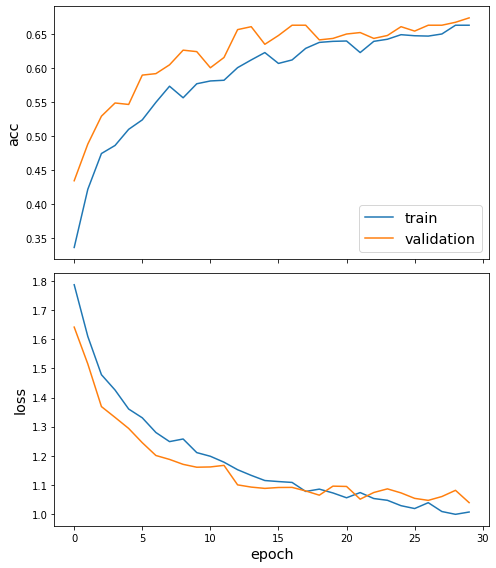

In [220]:
def build_and_run_model(batch_size=30, in_samples=[3,2], out_samples=[3,2], layer_sizes=[32,32], dropout=0.1, epochs=30):
    precisions, recalls, fscores = defaultdict(list), defaultdict(list), defaultdict(list)
    class_ratios = list()

    labels = nodes_df[["labelType"]]
    y = pd.Series(labels.iloc[:, 0], index=labels.index)

    for _ in range(1):
        gs = model_selection.GroupShuffleSplit(n_splits=1, train_size=.8, random_state=8)
        for train_ix, test_ix in gs.split(nodes_df, labels, groups=nodes_df['userId']):
            y_train, y_test = y[train_ix], y[test_ix]

            target_encoding = preprocessing.LabelBinarizer()
            train_targets = target_encoding.fit_transform(y_train)
            test_targets = target_encoding.transform(y_test)

            # Create the GraphSAGE model
            generator = DirectedGraphSAGENodeGenerator(square_features_weighted_directed, batch_size, in_samples, out_samples)
            train_gen = generator.flow(y_train.index, train_targets, shuffle=True)
            graphsage_model = DirectedGraphSAGE(
                layer_sizes=layer_sizes, 
                generator=generator, 
                bias=True,
                dropout=dropout,
                aggregator=MaxPoolingAggregator,
            )
            x_inp, x_out = graphsage_model.in_out_tensors()
            
            logits = layers.Dense(units=train_targets.shape[1], activation="linear")(x_out)
            prediction = layers.Activation(activation="softmax")(logits)

            # Model training
            model = Model(inputs=x_inp, outputs=prediction)
            model.compile(
                optimizer=optimizers.Adam(learning_rate=0.005),
                loss=losses.categorical_crossentropy,
                metrics=["acc"],
            )
            test_gen = generator.flow(y_test.index, test_targets)
            history = model.fit(
                train_gen, epochs=epochs, validation_data=test_gen, verbose=2, shuffle=True
            )

            # Draw the graph
            sg.utils.plot_history(history)

            test_metrics = model.evaluate(test_gen)
            print("\nTest Set Metrics:")
            for name, val in zip(model.metrics_names, test_metrics):
                print("\t{}: {:0.4f}".format(name, val))

            placetypes = labels.labelType.unique().tolist()
            predict_placetypes(y, y_test, generator, model, target_encoding, placetypes, class_ratios, precisions, recalls, fscores)

    print_class_ratios(class_ratios)
    
    print_pr_re_f1(precisions, recalls, fscores)

    return y, y_test, generator, x_inp, x_out, model, target_encoding, test_targets

y, y_test, generator, x_inp, x_out, model, target_encoding, test_targets = build_and_run_model()

### Build and run calibrated model (train-validation-test split)

16/16 [==============================] - 0s 13ms/step - loss: 1.1177 - acc: 0.6717

Test Set Metrics:
	loss: 1.1177
	acc: 0.6717
Accuracy: 0.6695464362850972
[[ 15   1   0  13   0   2   6   9]
 [  1  31   0   1   0   1   0   0]
 [  0   0   0   0   0   0   6   0]
 [  1   5   0  48   0   2   1   3]
 [  1   0   0   7   0   9   6   1]
 [  2   0   0   8   0  35  20   3]
 [  1   0   0  11   0   8 137   6]
 [  2   4   0   6   0   5   1  44]]
16/16 [==============================] - 0s 12ms/step - loss: 1.0821 - acc: 0.6393

Test Set Metrics:
	loss: 1.0821
	acc: 0.6393
Accuracy: 0.6457883369330454
[[ 18   0   0   8   0   4   6  10]
 [  0  31   0   1   0   1   0   1]
 [  0   0   0   0   0   1   5   0]
 [  4   6   0  34   0   4   7   5]
 [  0   0   0   5   0  12   6   1]
 [  1   0   0   6   0  40  20   1]
 [  1   0   0   5   0  20 132   5]
 [  3   3   0   5   0   7   0  44]]
16/16 [==============================] - 0s 11ms/step - loss: 1.0882 - acc: 0.6501

Test Set Metrics:
	loss: 1.0882
	acc: 

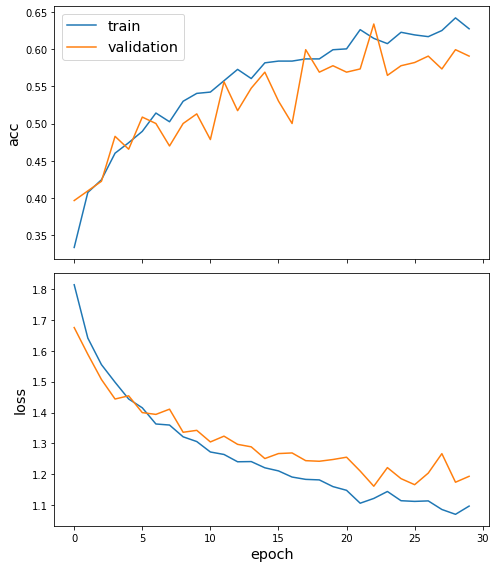

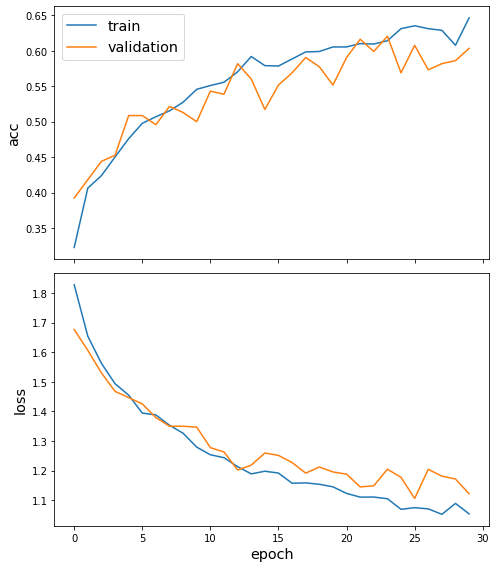

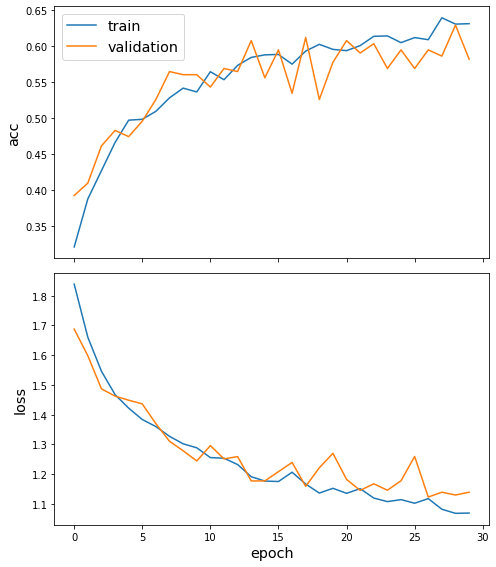

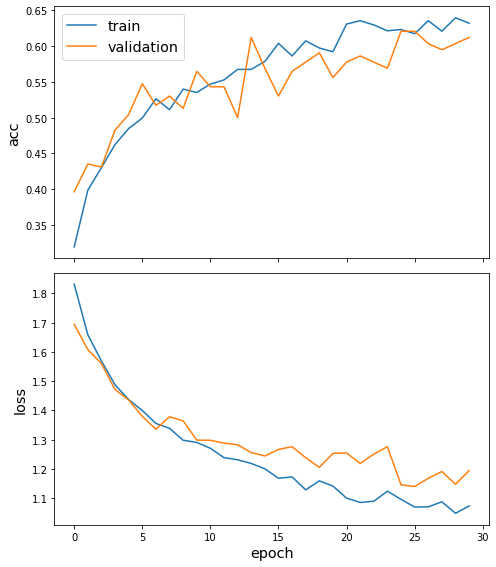

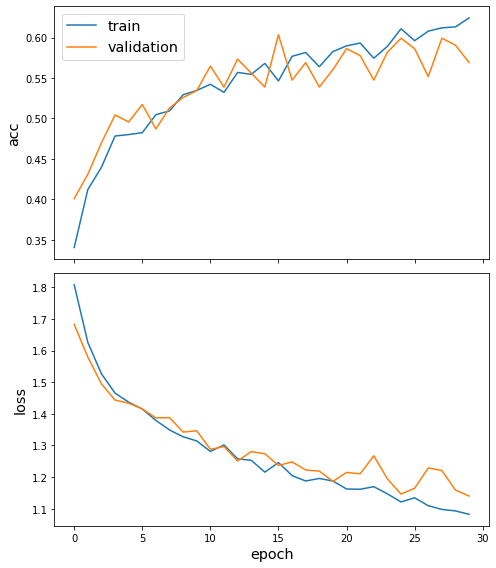

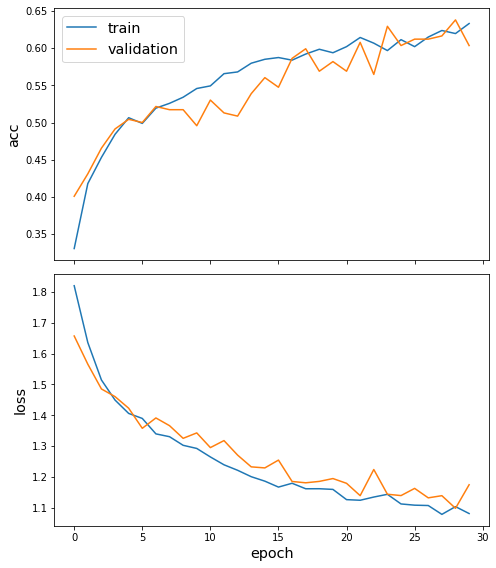

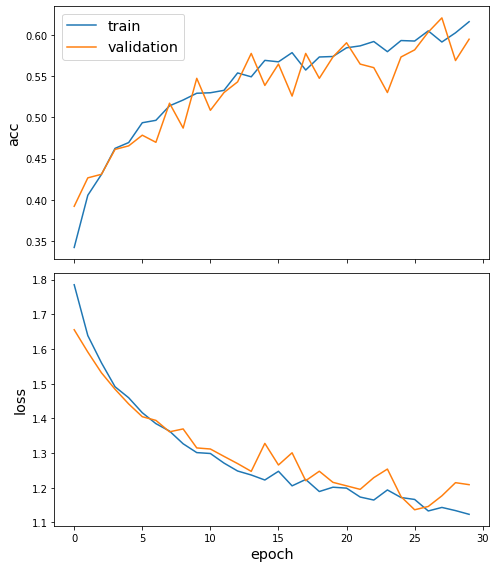

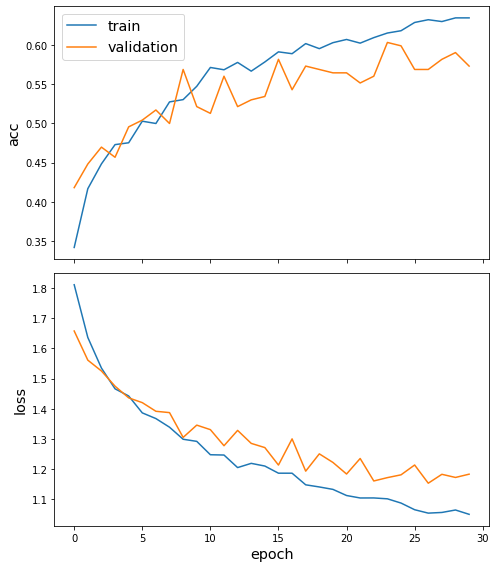

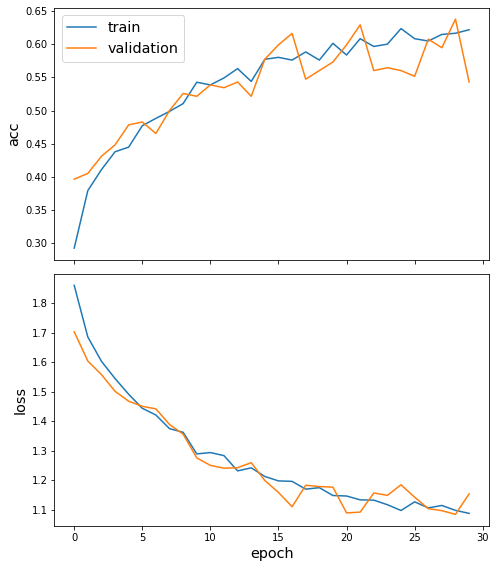

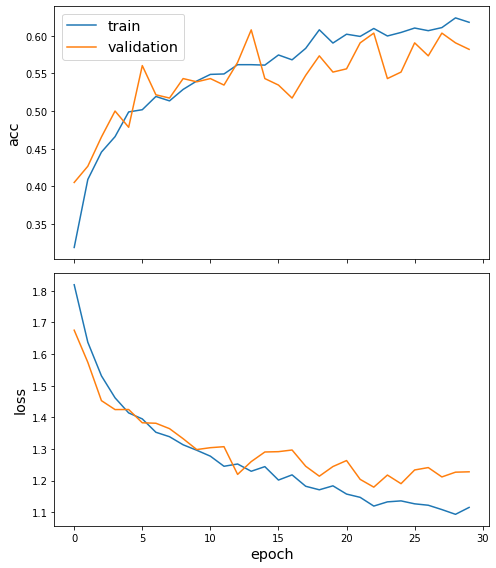

In [24]:
def build_and_run_model_with_calibration():
    precisions, recalls, fscores = defaultdict(list), defaultdict(list), defaultdict(list)
    class_ratios = list()
    
    labels = nodes_df[["labelType"]]
    y = pd.Series(labels.iloc[:, 0], index=labels.index)

    gs = model_selection.GroupShuffleSplit(n_splits=1, train_size=.8, random_state=8)
    for train_val_ix, test_ix in gs.split(nodes_df, labels, groups=nodes_df['userId']):
        nodes_train_val = nodes_df.loc[train_val_ix]
        nodes_train_val['index_col'] = nodes_train_val.index
        nodes_train_val = nodes_train_val.reset_index()
        
        labels_train_val = nodes_train_val[["labelType"]]
        y_train_val = y[train_val_ix]
        y_test = y[test_ix]

        for _ in range(10):
            gs = model_selection.GroupShuffleSplit(n_splits=1, train_size=.9, random_state=5)
            for train_ix_temp, val_ix_temp in gs.split(nodes_train_val, labels_train_val, groups=nodes_train_val['userId']):
                train_ix = nodes_train_val.loc[train_ix_temp].index_col.to_numpy()
                val_ix = nodes_train_val.loc[val_ix_temp].index_col.to_numpy()

                y_train = y_train_val[train_ix]
                y_val = y_train_val[val_ix]

                target_encoding = preprocessing.LabelBinarizer()

                train_targets = target_encoding.fit_transform(y_train)
                test_targets = target_encoding.transform(y_test)
                val_targets = target_encoding.transform(y_val)

                # Create the GraphSAGE model
                batch_size = 30
                in_samples = [3, 2]
                out_samples = [3, 2]
                generator = DirectedGraphSAGENodeGenerator(square_features_weighted_directed, batch_size, in_samples, out_samples)
                train_gen = generator.flow(y_train.index, train_targets, shuffle=True)
                graphsage_model = DirectedGraphSAGE(
                    layer_sizes=[32, 32], 
                    generator=generator, 
                    bias=True,
                    dropout=0.15,
                    aggregator=MaxPoolingAggregator,
                )
                x_inp, x_out = graphsage_model.in_out_tensors()

                logits = layers.Dense(units=train_targets.shape[1], activation="linear")(x_out)
                prediction = layers.Activation(activation="softmax")(logits)

                # Model training
                model = Model(inputs=x_inp, outputs=prediction)
                model.compile(
                    optimizer=optimizers.Adam(learning_rate=0.005),
                    loss=losses.categorical_crossentropy,
                    metrics=["acc"],
                )

                val_gen = generator.flow(y_val.index, val_targets)
                test_gen = generator.flow(y_test.index, test_targets)

                history = model.fit(
                    train_gen, epochs=30, validation_data=val_gen, verbose=0, shuffle=True
                )

                # Draw the graph
                sg.utils.plot_history(history)

                test_metrics = model.evaluate(test_gen)
                print("\nTest Set Metrics:")
                for name, val in zip(model.metrics_names, test_metrics):
                    print("\t{}: {:0.4f}".format(name, val))

                placetypes = labels.labelType.unique().tolist()
                predict_placetypes(y, y_test, generator, model, target_encoding, placetypes, class_ratios, precisions, recalls, fscores)

    print_class_ratios(class_ratios)
    
    print_pr_re_f1(precisions, recalls, fscores)
    
    return y, y_test, generator, test_gen, model, target_encoding, test_targets

y, y_test, generator, test_gen, model, target_encoding, test_targets = build_and_run_model_with_calibration()

### Build and run calibrated model with semi-supervised learning (train-validation-test split)

Epoch 1/30
86/86 - 6s - loss: 1.8320 - acc: 0.3259 - val_loss: 1.6583 - val_acc: 0.4052
Epoch 2/30
86/86 - 1s - loss: 1.6280 - acc: 0.3974 - val_loss: 1.5612 - val_acc: 0.4138
Epoch 3/30
86/86 - 2s - loss: 1.5154 - acc: 0.4572 - val_loss: 1.4860 - val_acc: 0.4569
Epoch 4/30
86/86 - 1s - loss: 1.4697 - acc: 0.4596 - val_loss: 1.4467 - val_acc: 0.4526
Epoch 5/30
86/86 - 1s - loss: 1.4451 - acc: 0.4760 - val_loss: 1.4168 - val_acc: 0.5216
Epoch 6/30
86/86 - 1s - loss: 1.4045 - acc: 0.4889 - val_loss: 1.4104 - val_acc: 0.4957
Epoch 7/30
86/86 - 1s - loss: 1.3701 - acc: 0.5129 - val_loss: 1.3994 - val_acc: 0.4871
Epoch 8/30
86/86 - 1s - loss: 1.3436 - acc: 0.5264 - val_loss: 1.3308 - val_acc: 0.5388
Epoch 9/30
86/86 - 1s - loss: 1.3403 - acc: 0.5199 - val_loss: 1.3298 - val_acc: 0.5129
Epoch 10/30
86/86 - 1s - loss: 1.3278 - acc: 0.5082 - val_loss: 1.3264 - val_acc: 0.5086
Epoch 11/30
86/86 - 1s - loss: 1.2916 - acc: 0.5188 - val_loss: 1.2985 - val_acc: 0.5431
Epoch 12/30
86/86 - 1s - loss:

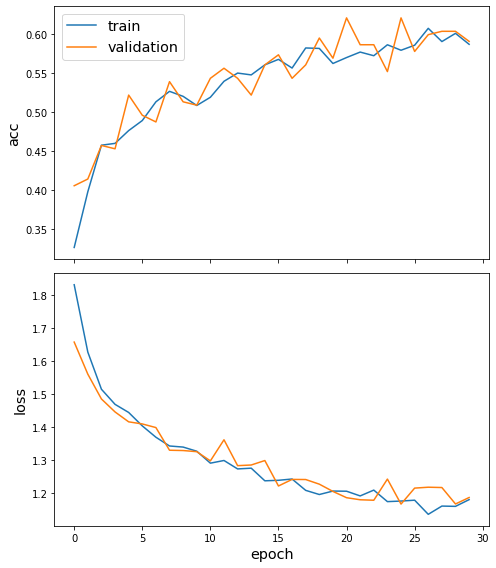

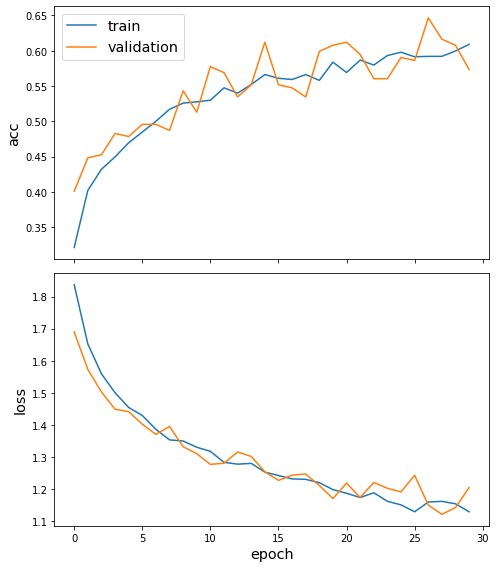

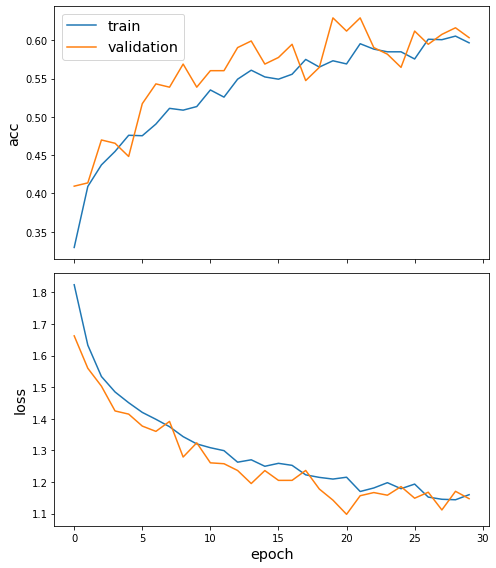

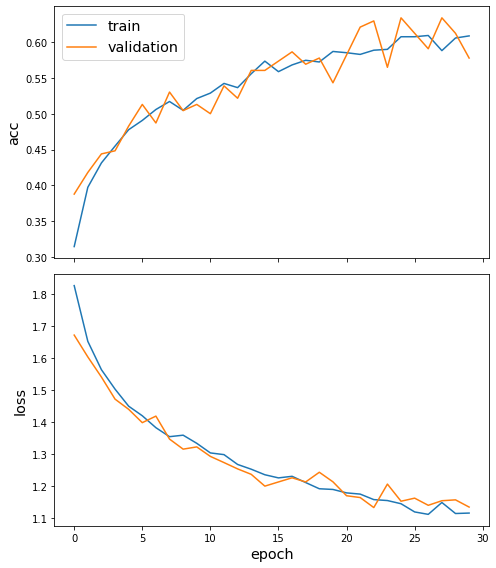

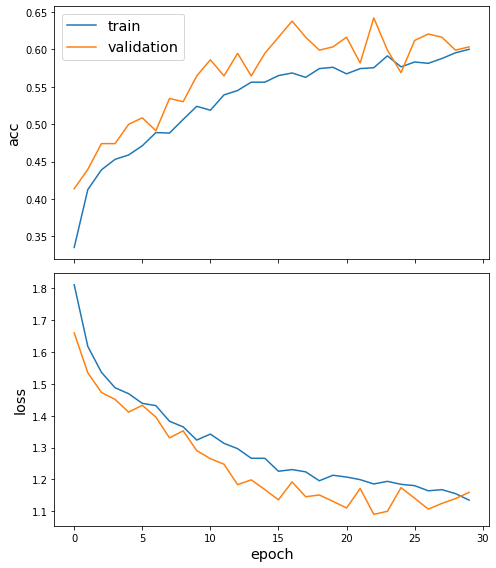

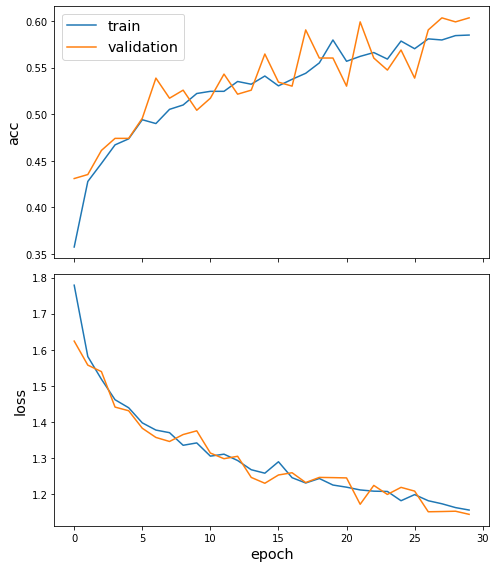

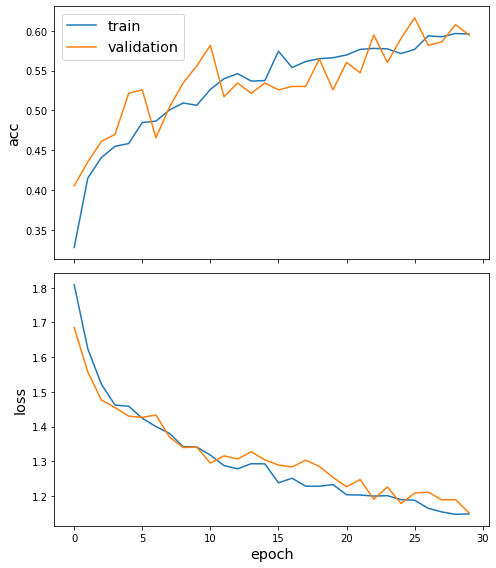

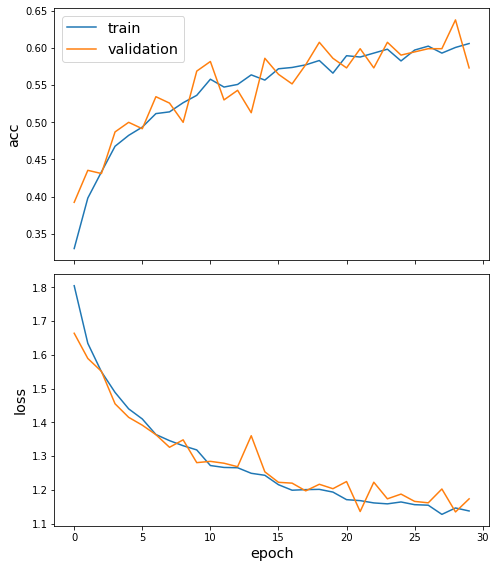

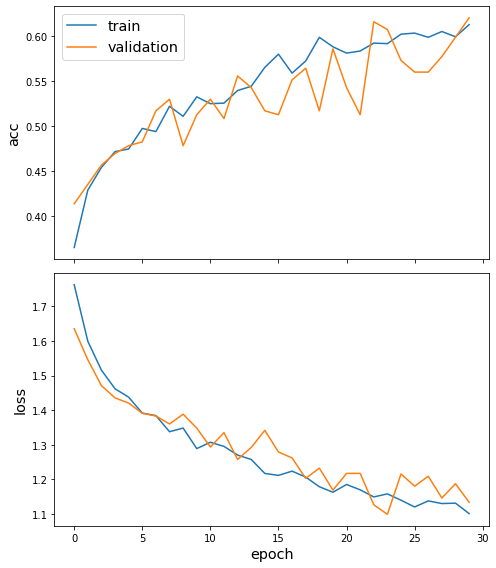

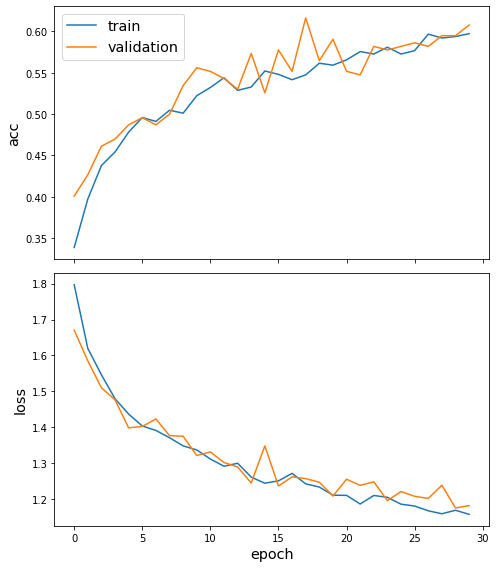

In [25]:
def semi_build_and_run_model_with_calibration():
    precisions, recalls, fscores = defaultdict(list), defaultdict(list), defaultdict(list)
    class_ratios = list()

    labels = nodes_df[["labelType"]]
    y = pd.Series(labels.iloc[:, 0], index=labels.index)

    gs = model_selection.GroupShuffleSplit(n_splits=1, train_size=.8, random_state=8)
    for train_val_ix, test_ix in gs.split(nodes_df, labels, groups=nodes_df['userId']):
        nodes_train_val = nodes_df.loc[train_val_ix]
        nodes_train_val['index_col'] = nodes_train_val.index
        nodes_train_val = nodes_train_val.reset_index()
        
        labels_train_val = nodes_train_val[["labelType"]]
        y_train_val = y[train_val_ix]
        y_test = y[test_ix]

        for _ in range(10):
            gs = model_selection.GroupShuffleSplit(n_splits=1, train_size=.9, random_state=5)
            for train_ix_temp, val_ix_temp in gs.split(nodes_train_val, labels_train_val, groups=nodes_train_val['userId']):
                train_ix = nodes_train_val.loc[train_ix_temp].index_col.to_numpy()
                val_ix = nodes_train_val.loc[val_ix_temp].index_col.to_numpy()

                y_train = y_train_val[train_ix]
                y_val = y_train_val[val_ix]

                target_encoding = preprocessing.LabelBinarizer()

                train_targets = target_encoding.fit_transform(y_train)
                test_targets = target_encoding.transform(y_test)
                val_targets = target_encoding.transform(y_val)

                # Create the GraphSAGE model
                batch_size = 20
                in_samples = [3, 2]
                out_samples = [3, 2]
                generator = DirectedGraphSAGENodeGenerator(square_features_weighted_directed, batch_size, in_samples, out_samples)
                train_gen = generator.flow(y_train.index, train_targets, shuffle=True)
                graphsage_model = DirectedGraphSAGE(
                    layer_sizes=[32, 32], 
                    generator=generator, 
                    bias=True,
                    dropout=0.2,
                    aggregator=MaxPoolingAggregator,
                )
                x_inp, x_out = graphsage_model.in_out_tensors()

                logits = layers.Dense(units=train_targets.shape[1], activation="linear")(x_out)
                prediction = layers.Activation(activation="softmax")(logits)

                # Model training
                model = Model(inputs=x_inp, outputs=prediction)
                model.compile(
                    optimizer=optimizers.Adam(learning_rate=0.005),
                    loss=losses.categorical_crossentropy,
                    metrics=["acc"],
                )

                val_gen = generator.flow(y_val.index, val_targets)
                test_gen = generator.flow(y_test.index, test_targets)

                history = model.fit(
                    train_gen, epochs=30, validation_data=val_gen, verbose=2, shuffle=True
                )

                # Draw the graph
                sg.utils.plot_history(history)

                test_metrics = model.evaluate(test_gen)
                print("\nTest Set Metrics:")
                for name, val in zip(model.metrics_names, test_metrics):
                    print("\t{}: {:0.4f}".format(name, val))

                placetypes = labels.labelType.unique().tolist()
                predict_placetypes(y, y_test, generator, model, target_encoding, placetypes, class_ratios, precisions, recalls, fscores)

    print_class_ratios(class_ratios)
    
    print_pr_re_f1(precisions, recalls, fscores)

    return y, y_test, generator, model, target_encoding, test_targets

y, y_test, generator, model, target_encoding, test_targets = semi_build_and_run_model_with_calibration()

Epoch 1/30
65/65 - 4s - loss: 1.8267 - acc: 0.3271 - val_loss: 1.6750 - val_acc: 0.4190
Epoch 2/30
65/65 - 1s - loss: 1.6351 - acc: 0.4051 - val_loss: 1.5318 - val_acc: 0.4644
Epoch 3/30
65/65 - 1s - loss: 1.5156 - acc: 0.4551 - val_loss: 1.3967 - val_acc: 0.5076
Epoch 4/30
65/65 - 1s - loss: 1.4256 - acc: 0.4959 - val_loss: 1.3182 - val_acc: 0.5702
Epoch 5/30
65/65 - 1s - loss: 1.3809 - acc: 0.5088 - val_loss: 1.3097 - val_acc: 0.5594
Epoch 6/30
65/65 - 1s - loss: 1.3430 - acc: 0.5243 - val_loss: 1.2617 - val_acc: 0.5724
Epoch 7/30
65/65 - 1s - loss: 1.3038 - acc: 0.5470 - val_loss: 1.2113 - val_acc: 0.5896
Epoch 8/30
65/65 - 1s - loss: 1.2563 - acc: 0.5635 - val_loss: 1.1903 - val_acc: 0.6156
Epoch 9/30
65/65 - 1s - loss: 1.2515 - acc: 0.5635 - val_loss: 1.1776 - val_acc: 0.6004
Epoch 10/30
65/65 - 1s - loss: 1.2048 - acc: 0.5841 - val_loss: 1.1680 - val_acc: 0.5896
Epoch 11/30
65/65 - 1s - loss: 1.1692 - acc: 0.5970 - val_loss: 1.1191 - val_acc: 0.6285
Epoch 12/30
65/65 - 1s - loss:

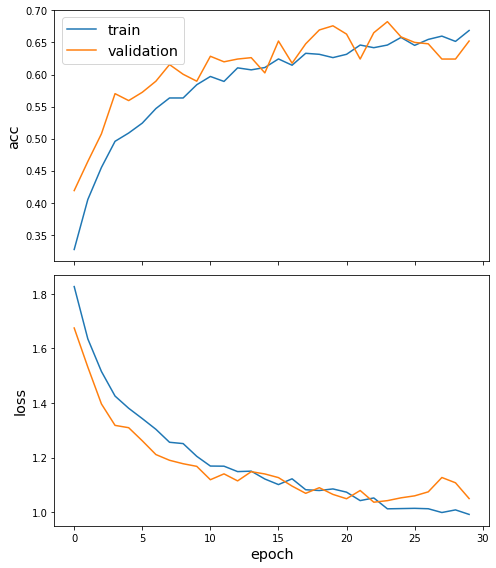

In [54]:
y, y_test, generator, x_inp, x_out, model, target_encoding, test_targets = build_and_run_model()

In [55]:
mapper_all = generator.flow(y.index)
embedding_model = Model(inputs=x_inp, outputs=x_out)
emb = embedding_model.predict(mapper_all)
X = emb
y_array = np.argmax(target_encoding.transform(y), axis=1)
X.shape

(2401, 32)

In [57]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=y.index)
    emb_transformed["label"] = y_array
else:
    emb_transformed = pd.DataFrame(X, index=y.index)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y_array

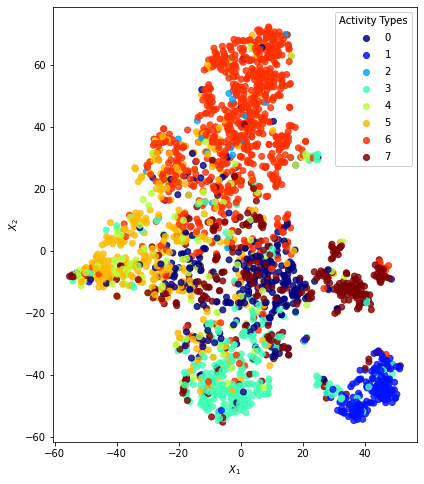

In [58]:
alpha = 0.8

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)

# produce a legend with the unique colors from the scatter
legend = ax.legend(*scatter.legend_elements(),
                   loc="upper right", title="Activity Types")
ax.add_artist(legend)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")

plt.show()

In [52]:
directed_neigh_type = [
    1 * (len(square_features_weighted_directed.in_nodes(node)) > 0) + 2 * (len(square_features_weighted_directed.out_nodes(node)) > 0)
    for node in y.index
]

print(f"{sum(nt==0 for nt in directed_neigh_type)} nodes have no in or out neighbours")
print(f"{sum(nt==1 for nt in directed_neigh_type)} nodes have in but not out neighbours")
print(f"{sum(nt==2 for nt in directed_neigh_type)} nodes have out but no in neighbours")
print(f"{sum(nt==3 for nt in directed_neigh_type)} nodes have in and out neighbours")

16 nodes have no in or out neighbours
35 nodes have in but not out neighbours
75 nodes have out but no in neighbours
2275 nodes have in and out neighbours


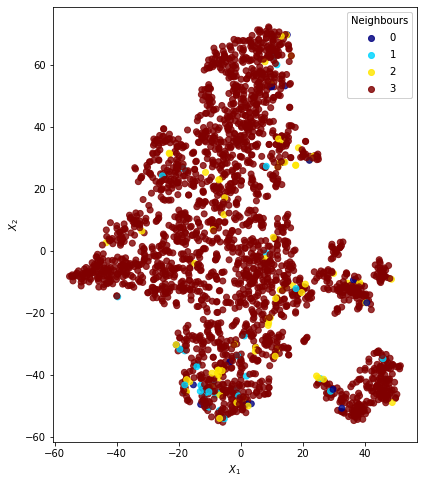

In [59]:
alpha = 0.8

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(
    emb_transformed[0], emb_transformed[1], c=directed_neigh_type, cmap="jet", alpha=alpha
)

# produce a legend with the unique colors from the scatter
legend = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Neighbours")
ax.add_artist(legend)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")

plt.show()

In [180]:
edges = get_edges(graph_df, nodes_df, ['distance', 'duration'])
nodes = get_nodes([typecount_normalized, poicount_normalized, hours_normalized, avg_hours_normalized, avg_dowDuration_normalized, speed_normalized])
square_features_weighted_directed = StellarDiGraph({"activities": nodes}, {"trip": edges})
print(square_features_weighted_directed.info())

StellarDiGraph: Directed multigraph
 Nodes: 2401, Edges: 11974

 Node types:
  activities: [2401]
    Features: float32 vector, length 260
    Edge types: activities-trip->activities

 Edge types:
    activities-trip->activities: [11974]
        Weights: all 1 (default)
        Features: float32 vector, length 2


Epoch 1/25
65/65 - 8s - loss: 1.8080 - acc: 0.3323 - val_loss: 1.6335 - val_acc: 0.4363
Epoch 2/25
65/65 - 1s - loss: 1.6075 - acc: 0.4283 - val_loss: 1.4553 - val_acc: 0.4903
Epoch 3/25
65/65 - 1s - loss: 1.4878 - acc: 0.4556 - val_loss: 1.3745 - val_acc: 0.5335
Epoch 4/25
65/65 - 1s - loss: 1.4119 - acc: 0.4892 - val_loss: 1.3200 - val_acc: 0.5508
Epoch 5/25
65/65 - 1s - loss: 1.3743 - acc: 0.5067 - val_loss: 1.2819 - val_acc: 0.5400
Epoch 6/25
65/65 - 1s - loss: 1.3309 - acc: 0.5335 - val_loss: 1.2602 - val_acc: 0.5680
Epoch 7/25
65/65 - 1s - loss: 1.3205 - acc: 0.5253 - val_loss: 1.2505 - val_acc: 0.5637
Epoch 8/25
65/65 - 1s - loss: 1.2770 - acc: 0.5593 - val_loss: 1.2049 - val_acc: 0.5702
Epoch 9/25
65/65 - 1s - loss: 1.2985 - acc: 0.5341 - val_loss: 1.2111 - val_acc: 0.5896
Epoch 10/25
65/65 - 1s - loss: 1.2524 - acc: 0.5635 - val_loss: 1.1710 - val_acc: 0.6199
Epoch 11/25
65/65 - 1s - loss: 1.2374 - acc: 0.5691 - val_loss: 1.1224 - val_acc: 0.6220
Epoch 12/25
65/65 - 1s - loss:

(0                          HOME
 1                      SHOPPING
 2                      SHOPPING
 3                   OTHERS HOME
 4                      SHOPPING
 5                      SHOPPING
 6                        HEALTH
 7                          WORK
 8                      SHOPPING
 9                          HOME
 10                         WORK
 11                     SHOPPING
 12                  OTHERS HOME
 13                         HOME
 14                       HEALTH
 15                     SHOPPING
 16                         WORK
 17                     SHOPPING
 18                       HEALTH
 19                       HEALTH
 20                         HOME
 21                         WORK
 22                  OTHERS HOME
 23                     SHOPPING
 24                     SHOPPING
 25                     SHOPPING
 26                         WORK
 27       PUBLIC DRINKING SPACES
 28       PUBLIC DRINKING SPACES
 29                  OTHERS HOME
 30       

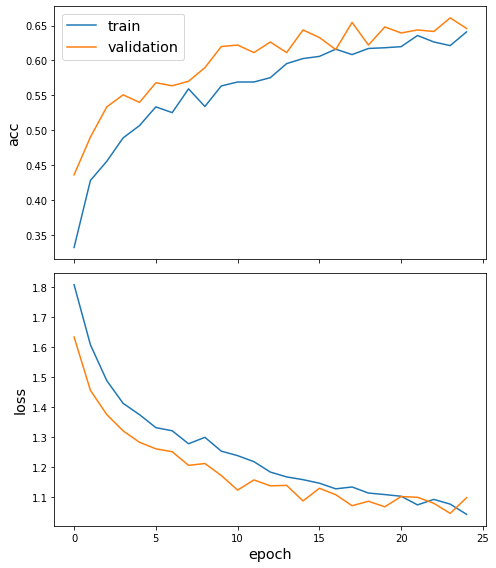

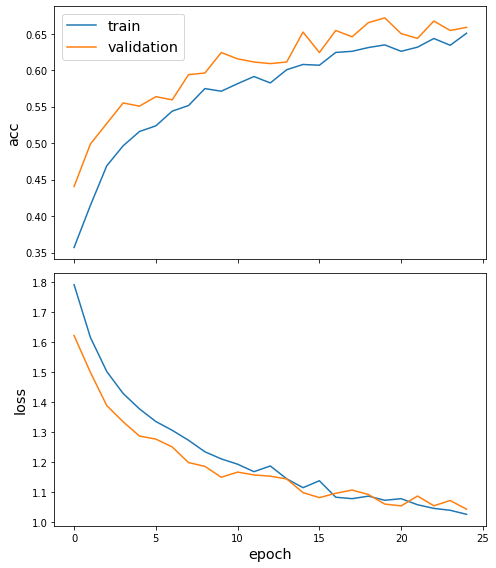

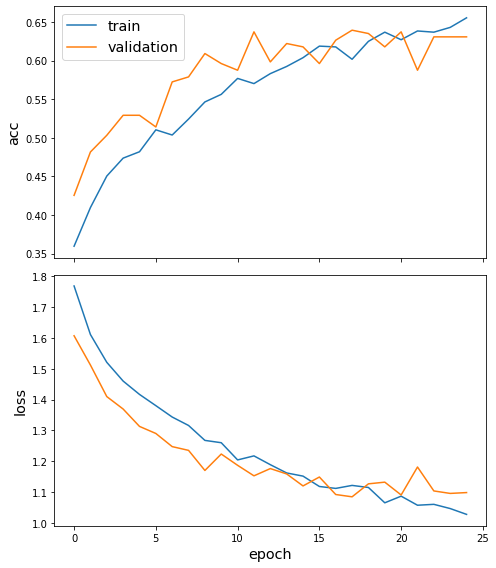

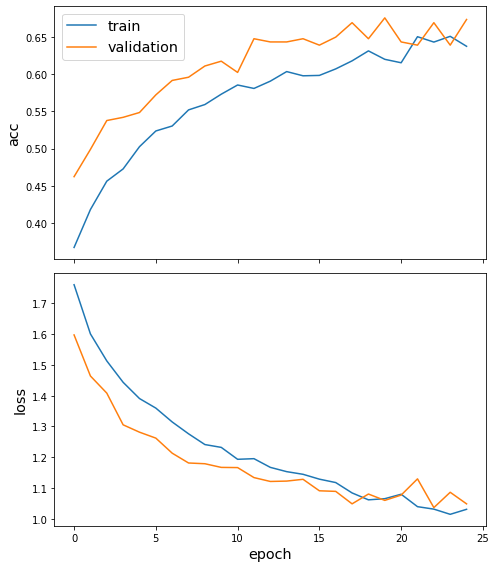

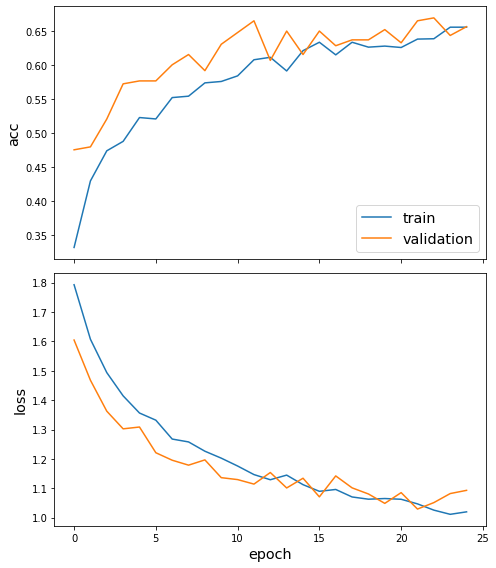

In [182]:
build_and_run_model(batch_size=30, in_samples=[3,2], out_samples=[3,2], layer_sizes=[32,32], dropout=0.1, epochs=25)